### Урок 4

In [109]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#### Задание 1

Cкачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [110]:
df = pd.read_csv('./data.csv', sep=',')

In [111]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


<b>recency</b> - months since last purchase<br>
<b>history</b> - $value of the historical purchases <br>
<b>used_discount</b> - indicates if the customer used a discount before<br>
<b>used_bogo</b> -  indicates if the customer used a buy one get one before<br>
<b>zip_code</b> - class of the zip code as Suburban/Urban/Rural <br>
<b>is_referral</b> - indicates if the customer was acquired from referral channel<br>
<b>offer</b> - the offers sent to the customers, Discount/But One Get One/No Offer <br>
<b>conversion</b> - customer conversion(buy or not)

#### Задание 2

Там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [112]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [113]:
df.treatment = np.where((df.treatment == 'No Offer'), 0, 1)

In [114]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [115]:
df.history.unique

<bound method Series.unique of 0        142.44
1        329.08
2        180.65
3        675.83
4         45.34
          ...  
63995    105.54
63996     38.91
63997     29.99
63998    552.94
63999    472.82
Name: history, Length: 64000, dtype: float64>

In [116]:
df = df.assign(client_idx = df.history * 100)

In [117]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,client_idx
0,10,142.44,1,0,Surburban,0,Phone,1,0,14244.0
1,6,329.08,1,1,Rural,1,Web,0,0,32908.0
2,7,180.65,0,1,Surburban,1,Web,1,0,18065.0


#### Задание 3

Cделать разбиение набора данных на тренировочную и тестовую выборки

In [118]:
df_features = df.drop(['target', 'treatment'], axis=1).copy()

In [119]:
df_results = df.drop(['target', 'treatment'], axis=1).copy()

In [120]:
df_features.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,client_idx
0,10,142.44,1,0,Surburban,0,Phone,14244.0
1,6,329.08,1,1,Rural,1,Web,32908.0
2,7,180.65,0,1,Surburban,1,Web,18065.0
3,9,675.83,1,0,Rural,1,Web,67583.0
4,2,45.34,1,0,Urban,0,Web,4534.0


In [121]:
X = df.drop(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'client_idx'], axis=1)
y = df.target
X.shape, y.shape

((64000, 2), (64000,))

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 2), (16000, 2), (48000,), (16000,))

In [123]:
df_train = X_train

In [124]:
df_test = X_test.drop(['treatment', 'target'], axis=1)

In [125]:
df_train.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,15976.0,0.105784,0.307570,0.0,0.0,0.0,0.0,1.0
1,32024.0,0.167656,0.373566,0.0,0.0,0.0,0.0,1.0


In [126]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [128]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': []
}

#### Задание 4

Cделать feature engineering на ваше усмотрение (допускается свобода выбора методов).

In [33]:
#cat_features = ['zip_code', 'channel']

#### Задание 5

Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями.

#### Вариант 1. Соло модель.

In [129]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

uplift@30%: 0.0790


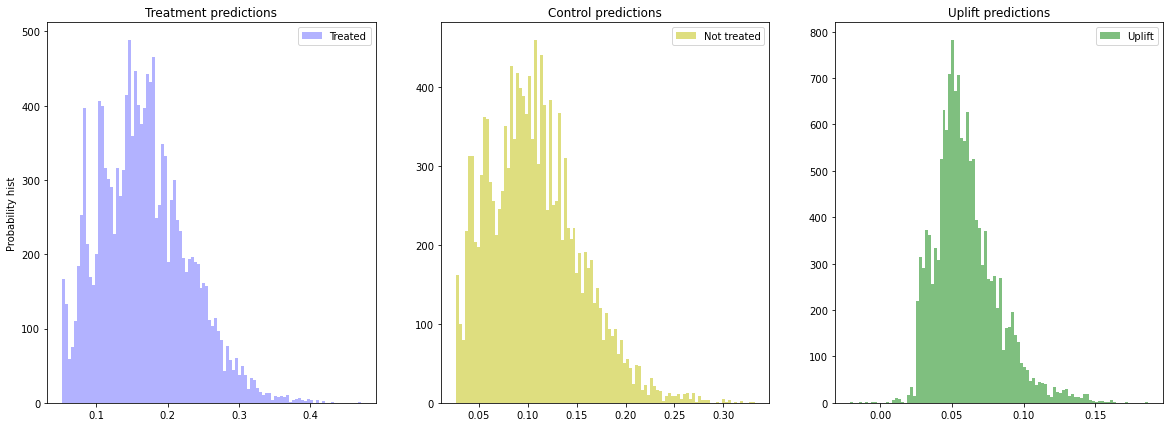

In [130]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [131]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,18.991764
1,treatment,18.206450
2,recency,13.206931
3,zip_code,11.282087
4,used_bogo,10.350647
5,channel,9.972290
6,history,7.271991
7,used_discount,6.667289
8,client_idx,4.050550


#### Вариант 2. Трансформация признаков.

In [132]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-132-6e5ebc9c94ea>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


#### Вариант 3. Две независисые модели.

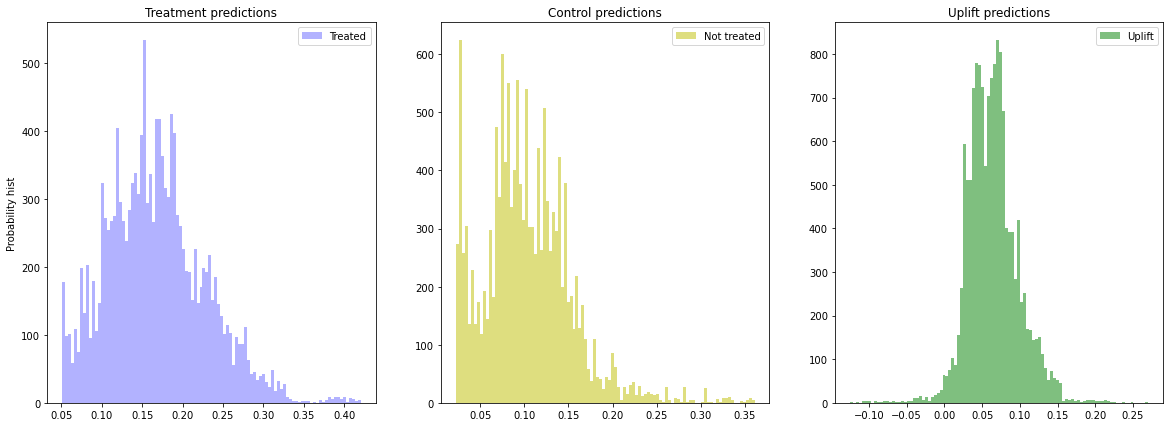

In [133]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### Задание 6

В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей.

In [134]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.079029
2,TwoModels,0.068570
1,ClassTransformation,0.063770


#### Задание 7

Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево.

#### Задание 8

(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

#### Задание 9

(опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево